# Cross-validation 
> Implement cross-validation to evaluate models on historical data

In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

Time series cross-validation is a method for evaluating how a model would have performed on historical data. It works by defining a sliding window across past observations and predicting the period following it. It differs from standard cross-validation by maintaining the chronological order of the data instead of randomly splitting it.

This method allows for a better estimation of our model's predictive capabilities by considering multiple periods. When only one window is used, it resembles a standard train-test split, where the test data is the last set of observations, and the training set consists of the earlier data.

The following graph showcases how time series cross-validation works. 

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

In this tutorial we'll explain how to perform cross-validation in `NeuralForecast`. 

**Outline:**
1. Install NeuralForecast

2. Load and plot the data 

3. Train multiple models using cross-validation

4. Evaluate models and select the best for each series

5. Plot cross-validation results

:::{.callout-warning collapse="true"}
## Prerequesites
This guide assumes basic familiarity with `neuralforecast`. For a minimal example visit the [Quick Start](./Getting_Started.ipynb)
:::

## 1. Install NeuralForecast

In [2]:
%%capture
!pip install neuralforecast

## 2. Load and plot the data 

We'll use pandas to load the hourly dataset from the [M4 Forecasting Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128), which has been stored in a parquet file for efficiency. 

In [3]:
import pandas as pd
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


The input to `neuralforecast` should be a data frame in long format with three columns: `unique_id`, `ds`, and `y`.

- `unique_id` (string, int, or category): A unique identifier for each time series. 

- `ds` (int or timestamp): An integer indexing time or a timestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS.

- `y` (numeric): The target variable to forecast.

This dataset contains 414 unique time series. To reduce the total execution time, we will use only the first 10. 

In [4]:
uids = Y_df['unique_id'].unique()[:10] # Select 10 ids to make the example run faster
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)

To plot the series, we'll use the `plot_series` method from `utilsforecast.plotting`. `utilsforecast` is a dependency of `neuralforecast` so it should be already installed. 

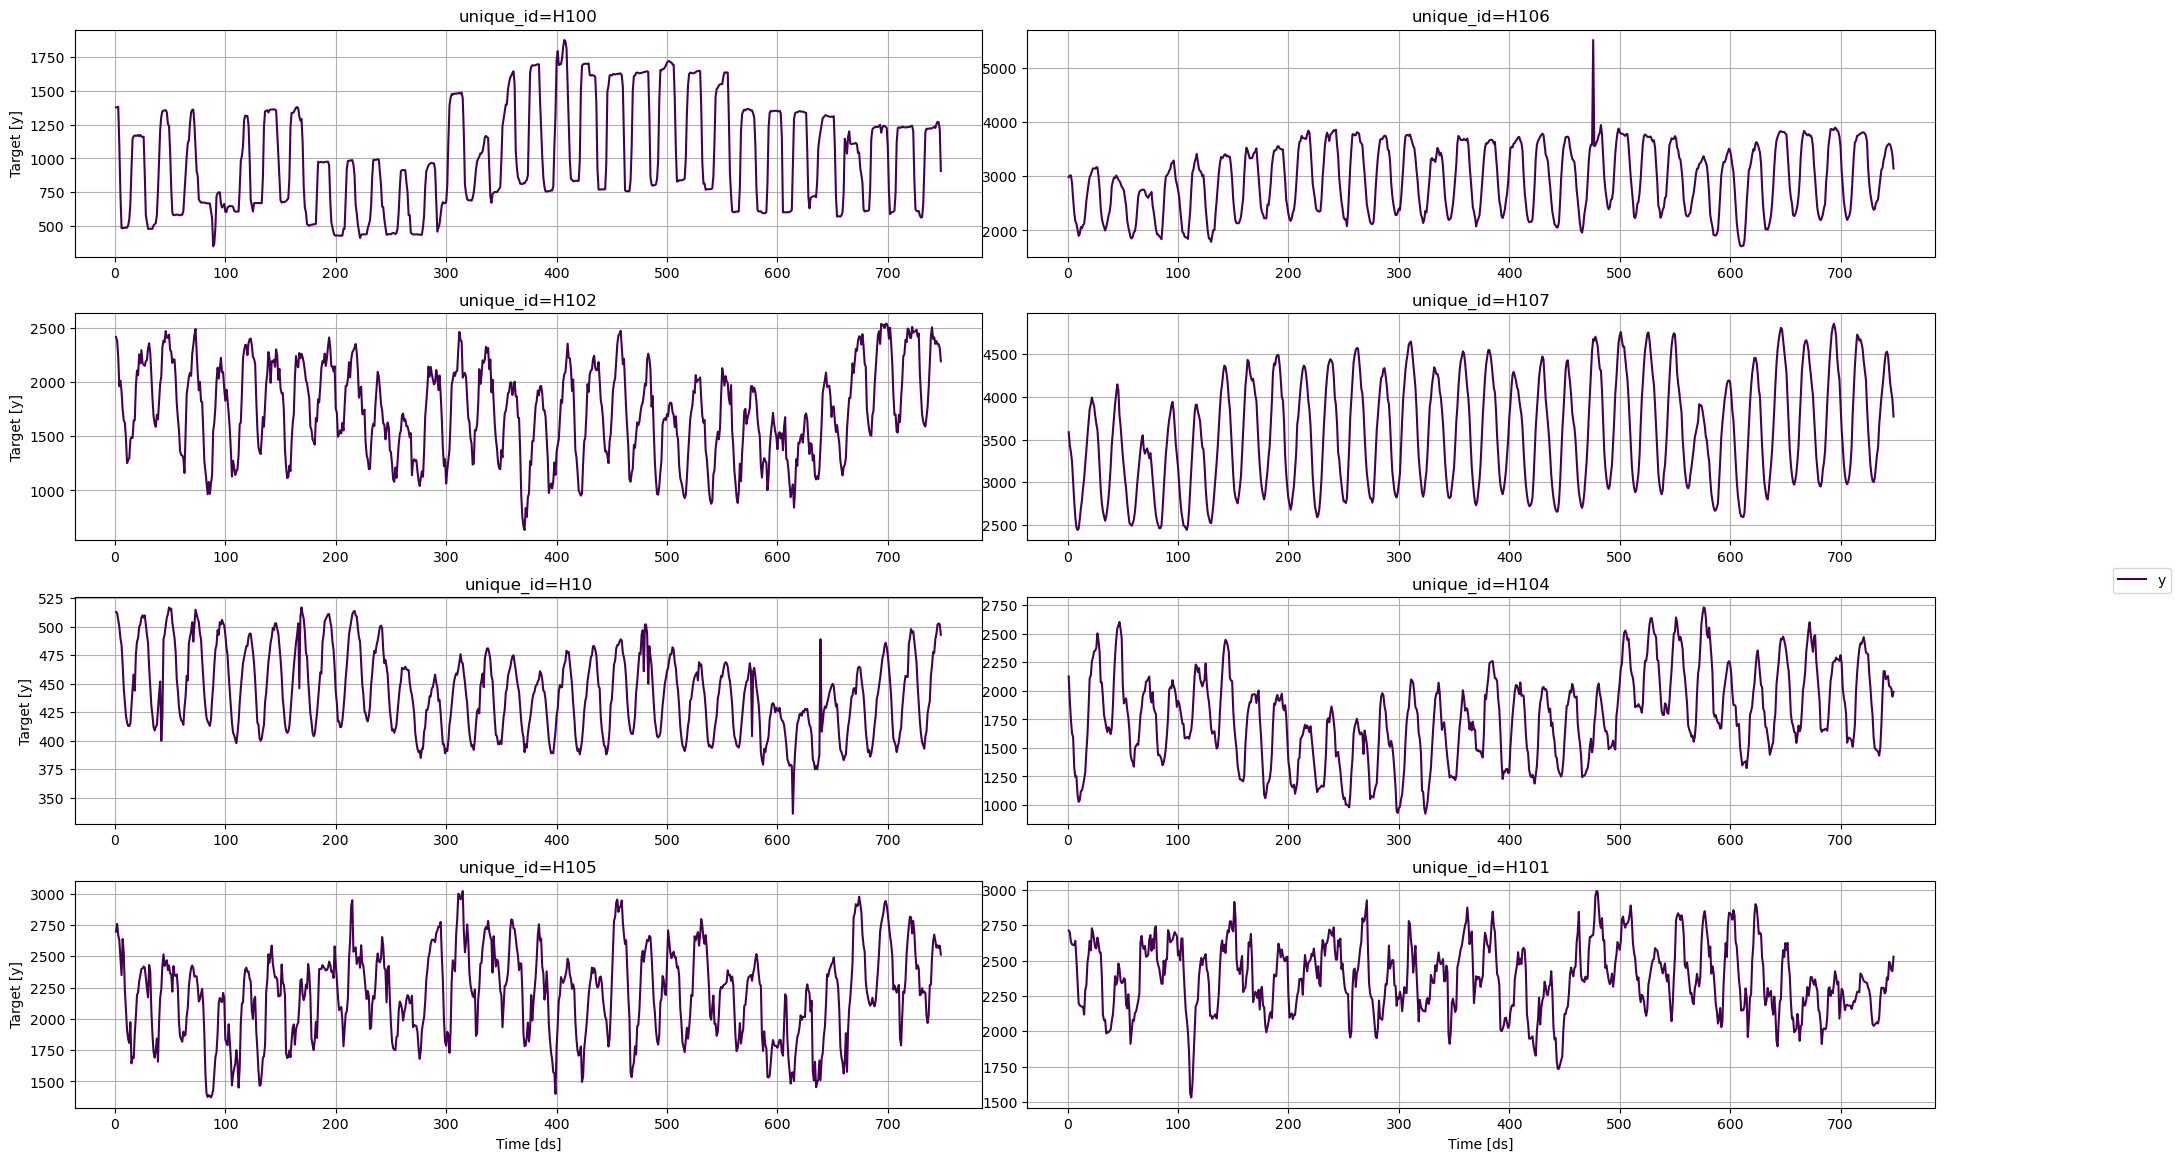

In [5]:
from utilsforecast.plotting import plot_series
plot_series(Y_df)

## 3. Train multiple models using cross-validation

We'll train different models from `neuralforecast` using the `cross-validation` method to decide which one perfoms best on the historical data. To do this, we need to import the `NeuralForecast` class and the models that we want to compare. 

In [6]:
from neuralforecast import NeuralForecast 
from neuralforecast.auto import AutoNHITS, AutoLSTM

/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:252: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),
/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:264: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:265: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M").values,
/Users/marianamenchero/Documents/neuralforecast/neuralforecast/utils.py:281: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will ch

In this tutorial, we'll use `auto` models, which automate the hyperparameter optimization process. To instantiate an `auto` model, you need to define the following parameters: 

- `h`: The forecasting horizon

- `loss`: The loss function to optimize.

- `config`: The hyperparameter search space. Default is `None`, and for this value, the `Auto` class will use a pre-defined suggested hyperparameter space.

- `search_alg`: The search algorithm to use. Default is random search. 

- `num_samples`: The number of configurations to explore. 

The forecasting horizon will be the same as in the M4 Competition, which is 48 steps ahead, so we'll set `horizon=48`. We'll use the Multi Quantile Loss (MQLoss) from `neuralforecast.losses.pytorch`, defined as the sum of the quantile losses for each target quantile. The quantile loss for a single quantile $\tau$ is given by:

\begin{equation*}
L_\tau(y, \hat{y}) = \begin{cases}
\tau \cdot (y - \hat{y}) & \text{if } y \geq \hat{y} \\
(1 - \tau) \cdot (\hat{y} - y) & \text{if } y < \hat{y}
\end{cases}
\end{equation*}

with $y$ the actual value and $\hat{y}$ the predicted value. For more details, see [here](https://nixtlaverse.nixtla.io/neuralforecast/losses.pytorch.html#multi-quantile-loss-mqloss). 

In [7]:
from neuralforecast.losses.pytorch import MQLoss

horizon = 48 
nf = NeuralForecast(
    models = [ # we'll use the default config and search_alg paramaters 
        AutoNHITS(h=horizon, loss=MQLoss(), num_samples=1),
        AutoLSTM(h=horizon, loss=MQLoss(), num_samples=1), 
    ], 
    freq = 1
)

The `cross_validation` method takes the following arguments: 

- `df`: The data frame in the format described in section 2. 

- `n_windows` (int): The number of windows to evaluate. Default is 1. 

- `step_size` (int): The number of steps to move the window forward. For example, when using daily data and `step_size=7`, the window moves a week forward. Default is 1.  

- `refit` (bool or int): Whether to retrain models for each cross-validation window. If `False`, the models are trained at the beginning and then used to predict each window. If a positive integer, the models are retrained every `refit` windows. Default is `False`.

In [34]:
%%capture
cv_df = nf.cross_validation(Y_df, n_windows=3)

2024-02-27 20:36:16,057	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
Seed set to 17
2024-02-27 20:37:47,629	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
Seed set to 13


It's worth mentioning that the default version of the `cross_validation` method in `neuralforecast` diverges from other libraries, where models are typically retrained at the start of each window. By default, it trains the models once and then uses them to generate predictions over all the windows, thus reducing the total execution time. For scenarios where the models need to be retrained, you can use the `refit` parameter to specify the number of windows after which the models should be retrained. 

In [39]:
cv_df.head()

,ds,cutoff,AutoNHITS-median,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoLSTM-median,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90,y
unique_id,,,,,,,,,,,,,
H1,699,698,735.202515,597.906372,661.070923,775.339661,784.399841,740.741516,688.674011,701.500183,776.421814,785.890076,739.0
H1,700,698,661.363281,523.950012,570.511902,742.375916,793.801025,699.781738,636.798401,655.425415,760.472412,779.716675,684.0
H1,701,698,603.969543,435.449219,491.102600,709.017700,765.597351,639.305420,564.895142,584.734131,719.360352,751.387085,619.0
H1,702,698,550.312134,372.971039,400.683044,653.551636,708.549866,572.712524,505.343872,521.167419,641.995850,669.903259,565.0
H1,703,698,466.030640,313.573029,361.403748,625.365295,647.292725,515.008606,456.323792,468.624207,569.493469,595.147827,532.0


The output of the `cross-validation` method is a data frame that includes the following columns:

- `unique_id`: The unique identifier for each time series. 

- `ds`: The timestamp or temporal index. 

- `cutoff`: The last timestamp or temporal index used in that cross-validation window. 

- `"model"`: Columns with the model’s point forecasts (median) and prediction intervals. By default, the 80 and 90% prediction intervals are included when using the MQLoss.

- `y`: The actual value.

## 4. Evaluate models and select the best for each series

To evaluate the point forecasts of the models, we'll use the Root Mean Squared Error (RMSE), defined as the square root of the mean of the squared differences between the actual and the predicted values. 

\begin{equation*}
RMSE = \sqrt{\frac{1}{h}\sum_{i=1}^{h}(y_i - \hat{y}_i)^2}
\end{equation*}


For convenience, we'll use the `evaluate` and the `rmse` functions from `datasetsforecast`.

In [40]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse 

The `evaluate` function takes the following arguments: 

- `df`: The data frame with the forecasts to evaluate. 

- `metrics` (list): The metrics to compute. 

- `models` (list): Names of the models to evaluate. Default is `None`, which uses all columns after removing `id_col`, `time_col`, and `target_col`. 

- `id_col` (str): Column that identifies unique ids of the series. Default is `unique_id`.

- `time_col` (str): Column with the timestamps or the temporal index. Default is `ds`.

- `target_col` (str): Column with the target variable. Default is `y`.

Notice that if we use the default value of `models`, then we need to exclude the `cutoff` column from the cross-validation data frame. We also need to reset its index to include the column with the unique ids. 

In [41]:
cv_df = cv_df.reset_index()
evaluation_df = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'], metrics=[rmse])

For each unique id, we'll select the model with the lowest RMSE. 

In [42]:
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df

,unique_id,metric,AutoNHITS-median,AutoLSTM-median,best_model
0,H1,rmse,52.555455,31.839996,AutoLSTM-median
1,H10,rmse,14.620822,12.164554,AutoLSTM-median
2,H100,rmse,200.950911,209.707009,AutoNHITS-median
3,H101,rmse,220.359801,122.170243,AutoLSTM-median
4,H102,rmse,178.588399,312.395666,AutoNHITS-median
5,H103,rmse,7803.995873,7133.835105,AutoLSTM-median
6,H104,rmse,141.002781,192.874483,AutoNHITS-median
7,H105,rmse,164.101887,146.778196,AutoLSTM-median
8,H106,rmse,206.422205,167.074600,AutoLSTM-median
9,H107,rmse,108.292887,144.414463,AutoNHITS-median


We can summarize the results to see how many times each model won. 

In [43]:
summary_df = evaluation_df.groupby(['metric', 'best_model']).size().sort_values().to_frame()
summary_df = summary_df.reset_index()
summary_df.columns = ['metric', 'model', 'num. of unique_ids']
summary_df

,metric,model,num. of unique_ids
0,rmse,AutoNHITS-median,4
1,rmse,AutoLSTM-median,6


With this information, we now know which model performs best for each series.

## 5. Plot cross-validation results

To visualize the cross-validation results, we will use the `plot_series` method again. We will need to rename the `y` column in the cross-validation data frame to avoid duplicates with the original data frame. We will also exclude the `cutoff` column and use the `max_insample_length argument` to plot only the last 200 observations for better visualization. 

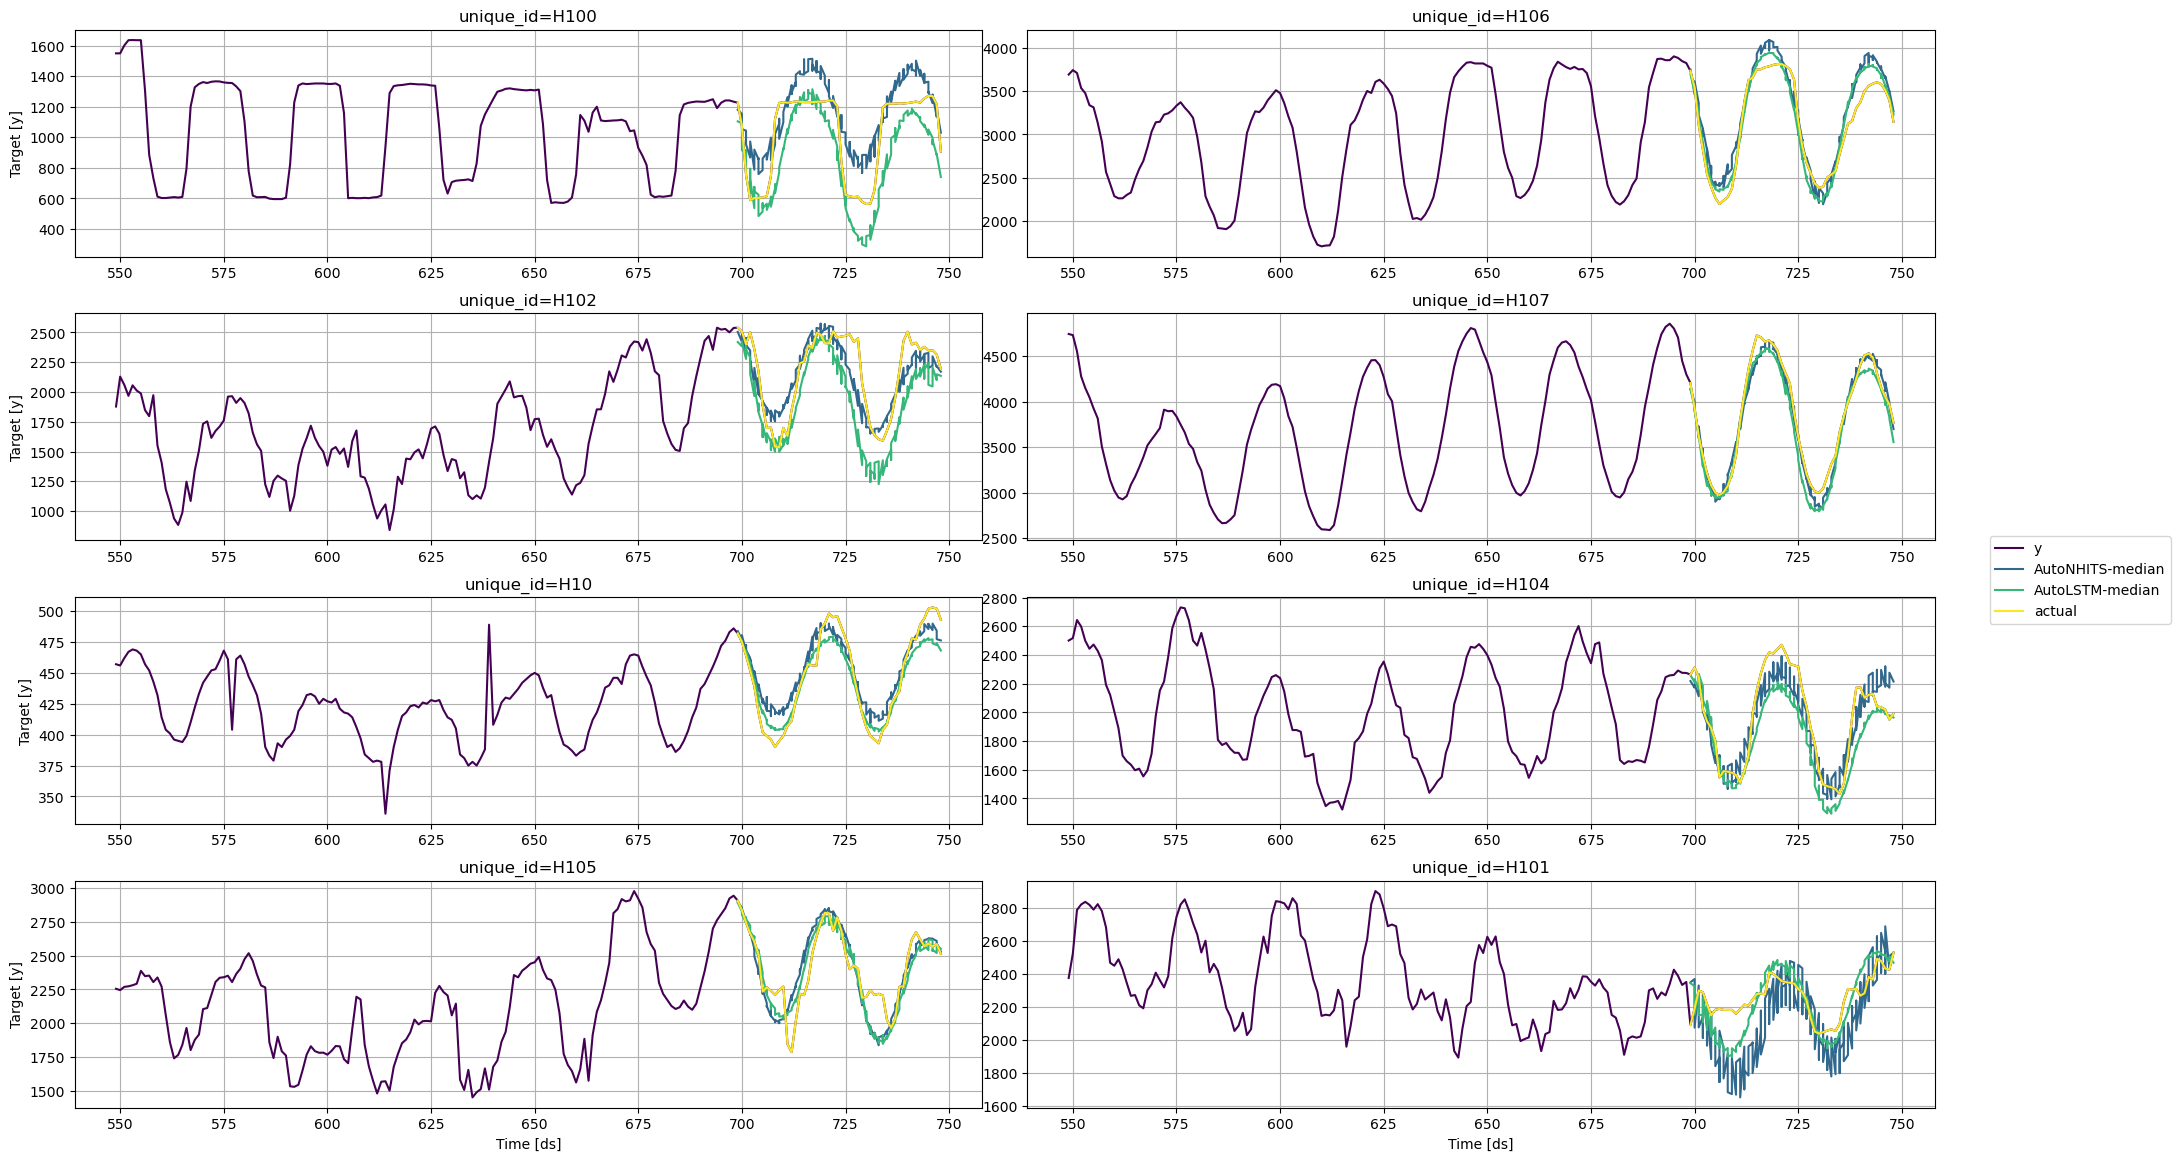

In [44]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values 
plot_series(Y_df, cv_df.loc[:, cv_df.columns != 'cutoff'], max_insample_length=200)